In [1]:
import pandas as pd
import numpy as np
import os

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter

import pickle as pkl
import matplotlib.pyplot as plt

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
# load events, confounds, timeseries df
events = pd.read_pickle('./derivatives/both/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/both/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/both/all_subjects_stn_timeseries.pkl')

# Select only PCA masks here
df = df[['signal_l_A', 'signal_l_B', 'signal_l_C', 'signal_r_A', 'signal_r_B', 'signal_r_C']]

events['onset'] -= 1.5  # STC

# Fit GLM with canonical HRF

### Following GdH's PhD thesis, we fit 4 different GLMs:
1. GLM1: (a) neutral cue, (b) payoff cue, (c) easy stimulus, and (d) hard stimulus. Its first main contrast of interest was ‘payoff cue > neutral cue’, the other main contrast was ‘hard stimulus > easy stimulus’
2. GLM2: (a) neutral cue, (b) payoff cue (left), (c) payoff cue (right), (d) easy stimulus, and (e) hard stimulus. The contrast of interest was “payoff cue (left) > payoff cue (right)”.
3. GLM3: (a) neutral cue, (b) payoff cue, (d) easy stimulus (correct), (e) easy stimulus (error), (f) hard stimulus (correct), and (g) hard stimulus (error). The main contrast: ‘hard stimulus (correct) > easy stimulus (correct)’
4. GLM4: (a) neutral cue, (b) potential payoff cue, (c) easy trials, (d) hard trials, (e) left responses, and (f) right responses. Contrast: Lateralization.

# GLM 1

In [3]:
events_1 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])]
events_1.loc[events_1['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm1 = GroupResponseFitter(df.copy(),
                           events_1, 
                           confounds=confounds,
                           input_sample_rate=1/3, 
                           oversample_design_matrix=20, 
                           concatenate_runs=True)
for event_type in events_1.event_type.unique():
    glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm1.fit()

# get timecourses
tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/si

### Statistics

,mask,t,p,p.fdr,contrast
0,signal_l_A,0.445596,0.658889,0.658889,glm1_cue
1,signal_l_B,0.976483,0.336150,0.504225,glm1_cue
2,signal_l_C,1.040012,0.306129,0.504225,glm1_cue
3,signal_r_A,1.423547,0.164255,0.492766,glm1_cue
4,signal_r_B,0.784824,0.438329,0.525994,glm1_cue
5,signal_r_C,1.752496,0.089267,0.492766,glm1_cue


,mask,t,p,p.fdr,contrast
0,signal_l_A,-0.483918,0.631739,0.80638,glm1_difficulty
1,signal_l_B,0.450710,0.655238,0.80638,glm1_difficulty
2,signal_l_C,-0.700531,0.488658,0.80638,glm1_difficulty
3,signal_r_A,-0.247138,0.806380,0.80638,glm1_difficulty
4,signal_r_B,-0.333660,0.740813,0.80638,glm1_difficulty
5,signal_r_C,-0.734042,0.468268,0.80638,glm1_difficulty


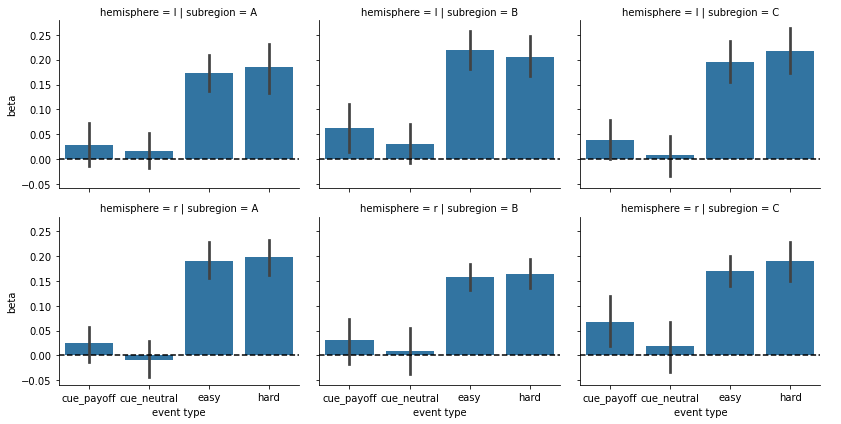

In [4]:
# ## to long format for plotting
GLM1_betas_long = glm1.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_payoff', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM1_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM1_betas_long['hemisphere'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1_betas_long['subregion'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot beta-values
fac = sns.FacetGrid(GLM1_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_payoff', 'cue_neutral', 'easy', 'hard'], ci=67)#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--').set(ylabel='beta')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, cue betas
results_cue = []
for roi in GLM1_betas_long.roi.unique():
    deg_free = GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_neutral'), 'beta'])
    results_cue.append({'mask': roi, 't': tval, 'p': pval})
results_cue = pd.DataFrame(results_cue)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_cue['p'], method='fdr_bh')
results_cue['p.fdr'] = p_fdr
results_cue['contrast'] = 'glm1_cue'
display(results_cue)

## statistics per ROI, stimulus betas
results_difficulty = []
for roi in GLM1_betas_long.roi.unique():
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'easy'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'hard'), 'beta'])
    results_difficulty.append({'mask': roi, 't': tval, 'p': pval})
results_difficulty = pd.DataFrame(results_difficulty)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_difficulty['p'], method='fdr_bh')
results_difficulty['p.fdr'] = p_fdr
results_difficulty['contrast'] = 'glm1_difficulty'
display(results_difficulty)

In [5]:
# # Save the betas for the model-based analyses in notebook 7
GLM1_betas_long.to_pickle('./derivatives/both/STN_GLM_betavalues.pkl')

## Get Bayes Factors, use R

In [6]:
GLM1_betas_long1 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,roi,event_type,subject,beta,hemisphere,subregion
0,signal_l_A,cue_payoff,1,0.003243,l,A
1,signal_l_A,cue_payoff,2,-0.477352,l,A
2,signal_l_A,cue_payoff,3,-0.013226,l,A
3,signal_l_A,cue_payoff,4,0.011756,l,A
4,signal_l_A,cue_payoff,5,0.261846,l,A


In [7]:
%%R -i GLM1_betas_long1 -i results_cue -o results_cue
library(BayesFactor)

b1 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'A','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'B','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'C','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'A','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'B','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'C','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'C','beta'], paired=TRUE)

results_cue$bf10 <- NA
results_cue[results_cue$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_cue[results_cue$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_cue[results_cue$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_cue[results_cue$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_cue[results_cue$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_cue[results_cue$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))  # substanial evidence against
print(paste0('BF10 for L B: ', extractBF(b2)$bf))  # anecdotal evidence for
print(paste0('BF10 for L C: ', extractBF(b3)$bf))  # anecdotal evidence for
print(paste0('BF10 for R A: ', extractBF(b4)$bf))  # substanial evidence against
print(paste0('BF10 for R B: ', extractBF(b5)$bf))  # anecdotal evidence against
print(paste0('BF10 for R C: ', extractBF(b6)$bf))  # substanial evidence against



Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



[1] "BF10 for L A: 0.204231603735351"
[1] "BF10 for L B: 0.288718416684088"
[1] "BF10 for L C: 0.305953479823371"
[1] "BF10 for R A: 0.466135216594435"
[1] "BF10 for R B: 0.247550664814839"
[1] "BF10 for R C: 0.73292184975162"


## Model building

Model beta values ~ event_type * hemipshere * subregion, and use model comparison to quantify evidence for/against specific independent variables

In [8]:
GLM1_betas_long1 = GLM1_betas_long1.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,roi,event_type,subject,beta,hemisphere,subregion
0,signal_l_A,cue_payoff,1,0.003243,l,A
1,signal_l_A,cue_payoff,2,-0.477352,l,A
2,signal_l_A,cue_payoff,3,-0.013226,l,A
3,signal_l_A,cue_payoff,4,0.011756,l,A
4,signal_l_A,cue_payoff,5,0.261846,l,A


In [9]:
GLM1_betas_long1 = GLM1_betas_long1.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()  #aggregate across hemispheres within subjects

In [10]:
%%R -i GLM1_betas_long1
library(BayesFactor, lib.loc='/usr/local/lib/R/site-library')
library('report', lib.loc='/usr/local/lib/R/site-library')
library('lme4', lib.loc='/usr/local/lib/R/site-library')
library('lmerTest', lib.loc='/usr/local/lib/R/site-library')

GLM1_betas_long1$subject <- factor(GLM1_betas_long1$subject)
GLM1_betas_long1$event_type <- factor(GLM1_betas_long1$event_type)
#GLM1_betas_long1$hemisphere <- factor(GLM1_betas_long1$hemisphere)
GLM1_betas_long1$subregion <- factor(GLM1_betas_long1$subregion)

# Bayes
bfTests <- generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all')
print(1/bfTests)
# print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))
# print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject),GLM1_betas_long1) 
# print(summary(lmod))
print(anova(lmod))

r <- report(lmod, df_method='satterthwaite')
print(r)
print(table_long(r))

print(report(anova(lmod)))
print(t(bfTests))

Attaching package: ‘lmerTest’



    lmer



    step




  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   4.368202  17.15056             10.63719
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               76.50091                          46.78188
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         185.8569
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      801.4758
Type III Analysis of Variance Table with Satterthwaite's method
                       Sum Sq  Mean Sq NumDF DenDF F value  Pr(>F)  
event_type           0.043688 0.043688     1   160  2.7661 0.09824 .
subregion            0.013725 0.006862     2   160  0.4345 0.64836  
event_type:subregion 0.002299 0.001149     2 

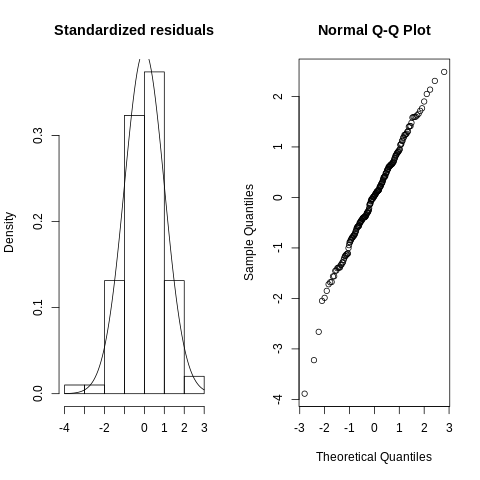

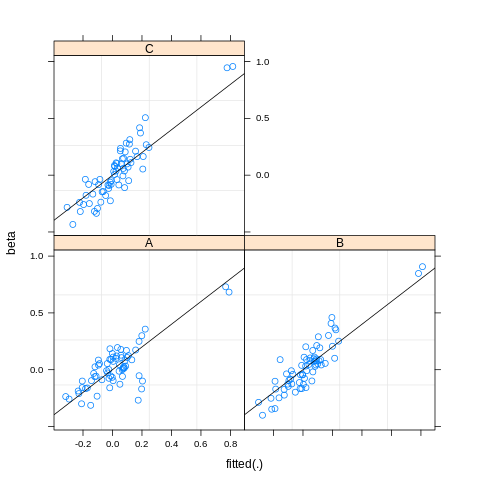

In [11]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

### Repeat the t-tests and LMEMs, using the stimuli-betas as DVs

In [12]:
GLM1_betas_long2 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['easy', 'hard'])]
GLM1_betas_long2 = GLM1_betas_long2.rename(columns={'event type': 'event_type'})


In [13]:
%%R -i GLM1_betas_long2 -i results_difficulty -o results_difficulty
library(BayesFactor)

GLM1_betas_long2$event_type <- factor(GLM1_betas_long2$event_type)
GLM1_betas_long2$hemisphere <- factor(GLM1_betas_long2$hemisphere)
GLM1_betas_long2$subregion <- factor(GLM1_betas_long2$subregion)

b1 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'A','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'B','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'C','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'A','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'B','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'C','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'C','beta'], paired=TRUE)

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

results_difficulty$bf10 <- NA
results_difficulty[results_difficulty$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_difficulty[results_difficulty$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_difficulty[results_difficulty$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_difficulty[results_difficulty$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_difficulty[results_difficulty$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_difficulty[results_difficulty$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

[1] "BF10 for L A: 0.207631507565095"
[1] "BF10 for L B: 0.204666123066305"
[1] "BF10 for L C: 0.23372949357064"
[1] "BF10 for R A: 0.191591704769078"
[1] "BF10 for R B: 0.196124526001354"
[1] "BF10 for R C: 0.238948738188237"


In [14]:
GLM1_betas_long2 = GLM1_betas_long2.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()  #aggregate across hemispheres within subjects

In [15]:
%%R -i GLM1_betas_long2 -i results_difficulty -o results_difficulty

# Models
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long2, whichModels='all'))

lmod <- lmer(beta~event_type*subregion + (1|subject), GLM1_betas_long2) 
summary(lmod)
anova(lmod)

  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   6.125917  18.76863             10.31328
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only                116.611                          65.63883
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         200.8193
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      1171.391
Type III Analysis of Variance Table with Satterthwaite's method
                        Sum Sq   Mean Sq NumDF DenDF F value Pr(>F)
event_type           0.0041237 0.0041237     1   160  0.2806 0.5970
subregion            0.0019936 0.0009968     2   160  0.0678 0.9344
event_type:subregion 0.0043175 0.0021587     2  

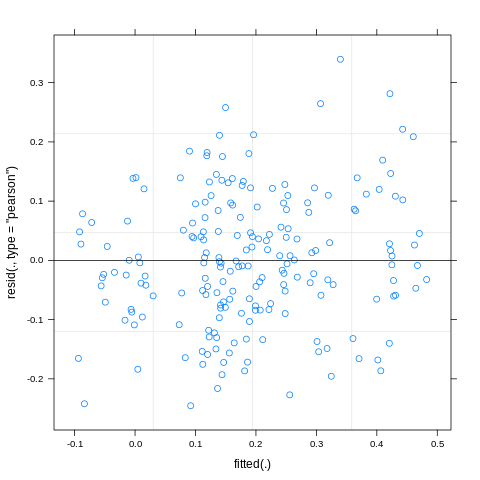

In [16]:
%%R
plot(lmod)

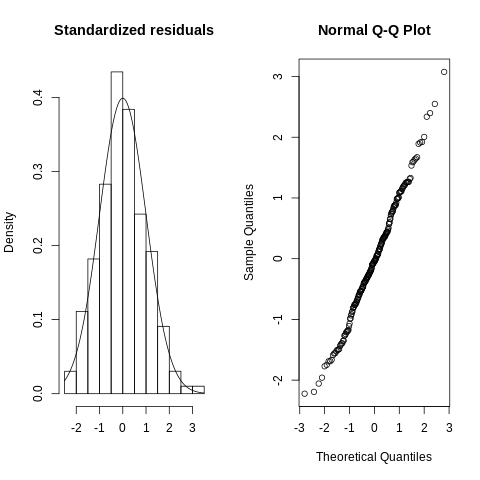

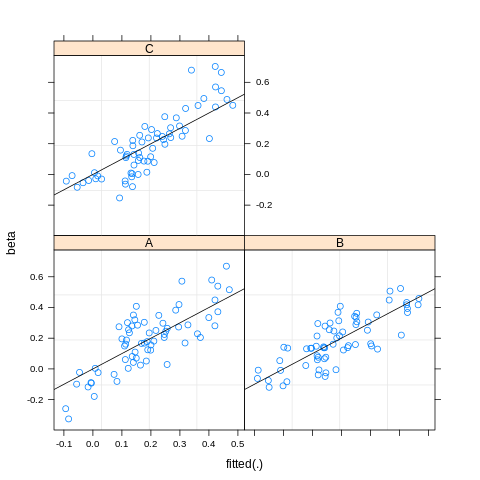

In [17]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

# GLM 2

In [18]:
events_2 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])].copy()

glm2 = GroupResponseFitter(df.copy(), 
                            events_2, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_2.event_type.unique():
    glm2.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm2.fit()

# get timecourses
tc = glm2.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Statistics

,mask,t,p,p.fdr,contrast
0,signal_l_A,-0.014335,0.988651,0.988651,glm2_cues
1,signal_l_B,0.856138,0.398287,0.768726,glm2_cues
2,signal_l_C,-0.926666,0.361037,0.768726,glm2_cues
3,signal_r_A,-0.812630,0.422435,0.768726,glm2_cues
4,signal_r_B,-0.662358,0.512484,0.768726,glm2_cues
5,signal_r_C,0.127544,0.899308,0.988651,glm2_cues


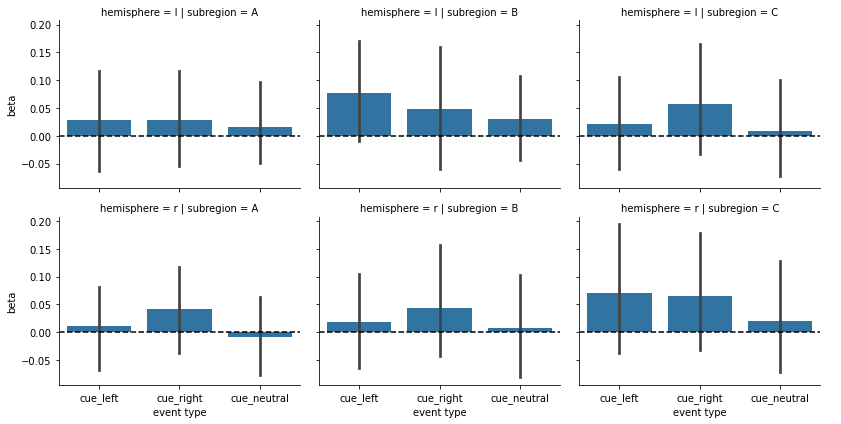

In [19]:
# ## long format for plotting
GLM2_betas_long = glm2.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM2_betas_long.columns = ['roi', 'event type', 'subject', 'beta']

GLM2_betas_long['hemisphere'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM2_betas_long['subregion'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM2_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral'])#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM2_betas_long.roi.unique():
    deg_free = GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_left'), 'beta'],
                                       GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_right'), 'beta'])
    #print("Subregion {}, contrast cue_left != cue_right, t({}) = {:.4f}, p = {:.4f}".format(roi, deg_free, tval, pval))
    results.append({'mask': roi, 't': tval, 'p': pval})

results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm2_cues'
display(results)
results_glm2 = results.copy()

In [20]:
GLM2_betas_longR = GLM2_betas_long.loc[GLM2_betas_long['event type'].isin(['cue_left', 'cue_right'])]
GLM2_betas_longR = GLM2_betas_longR.rename(columns={'event type': 'event_type'})

GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion,event_type2
0,signal_l_A,cue_left,1,0.011619,l,A,ipsilateral
1,signal_l_A,cue_left,2,-0.505599,l,A,ipsilateral
2,signal_l_A,cue_left,3,-0.021296,l,A,ipsilateral
3,signal_l_A,cue_left,4,0.102749,l,A,ipsilateral
4,signal_l_A,cue_left,5,0.195106,l,A,ipsilateral
...,...,...,...,...,...,...,...
886,signal_r_C,cue_right,30,0.018121,r,C,ipsilateral
887,signal_r_C,cue_right,31,-0.390840,r,C,ipsilateral
888,signal_r_C,cue_right,32,-0.185252,r,C,ipsilateral
889,signal_r_C,cue_right,33,-0.145322,r,C,ipsilateral


In [21]:
GLM2_betas_longR2 = GLM2_betas_longR.groupby(['subject', 'event_type2', 'subregion']).beta.mean().reset_index()  # Aggregate within subject (ie mean hemispheres)

In [22]:
%%R -i GLM2_betas_longR -i results_glm2 -i GLM2_betas_longR2 -o results_glm2
library(BayesFactor)
GLM2_betas_longR$laterality <- factor(GLM2_betas_longR$event_type2)
GLM2_betas_longR$hemisphere <- factor(GLM2_betas_longR$hemisphere)
GLM2_betas_longR$subregion <- factor(GLM2_betas_longR$subregion)

b1 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

results_glm2$bf10 <- NA
results_glm2[results_glm2$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm2[results_glm2$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm2[results_glm2$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm2[results_glm2$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm2[results_glm2$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm2[results_glm2$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

# Bayes
GLM2_betas_longR2$laterality <- factor(GLM2_betas_longR2$event_type2)
print(1/generalTestBF(beta ~ 1 + laterality*subregion, whichRandom="subject", data = GLM2_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~laterality*subregion + (1|subject), GLM2_betas_longR2) 
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.186232134302287"
[1] "BF10 for L B: 0.261156174942102"
[1] "BF10 for L C: 0.276552372537783"
[1] "BF10 for R A: 0.252634962339802"
[1] "BF10 for R B: 0.228201618878542"
[1] "BF10 for R C: 0.187632569765961"
  |======================================================================| 100%
                denominator
numerator        laterality subregion laterality:subregion
  Intercept only   6.325275   15.8996             9.430994
                denominator
numerator        laterality + subregion laterality + laterality:subregion
  Intercept only               96.68883                          59.47915
                denominator
numerator        subregion + laterality:subregion
  Intercept only                         153.7834
                denominator
numerator        laterality + subregion + laterality:subregion
  Intercept only                                      989.9102
Type III Analysis of Variance Table with Satterthwaite's method
                        

In [23]:
# %%R -i GLM2_betas_longR -i results_glm2 -o results_glm2
# library(BayesFactor)
# GLM2_betas_longR$laterality <- factor(GLM2_betas_longR$event_type2)
# GLM2_betas_longR$hemisphere <- factor(GLM2_betas_longR$hemisphere)
# GLM2_betas_longR$subregion <- factor(GLM2_betas_longR$subregion)

# b1 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)

# b2 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)

# b3 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

# b4 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)
# b5 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)
# b6 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'],
#         GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

# print(paste0('BF10 for L A: ', extractBF(b1)$bf))
# print(paste0('BF10 for L B: ', extractBF(b2)$bf))
# print(paste0('BF10 for L C: ', extractBF(b3)$bf))
# print(paste0('BF10 for R A: ', extractBF(b4)$bf))
# print(paste0('BF10 for R B: ', extractBF(b5)$bf))
# print(paste0('BF10 for R C: ', extractBF(b6)$bf))

# results_glm2$bf <- NA
# results_glm2[results_glm2$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
# results_glm2[results_glm2$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
# results_glm2[results_glm2$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
# results_glm2[results_glm2$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
# results_glm2[results_glm2$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
# results_glm2[results_glm2$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

# # Bayes
# print(generalTestBF(beta ~ 1 + laterality*subregion, whichRandom="subject", data = GLM2_betas_longR, whichModels='all'))

# # Frequentist
# lmod <- lmer(beta~laterality*subregion + (1|subject), GLM2_betas_longR) 
# summary(lmod)
# anova(lmod)

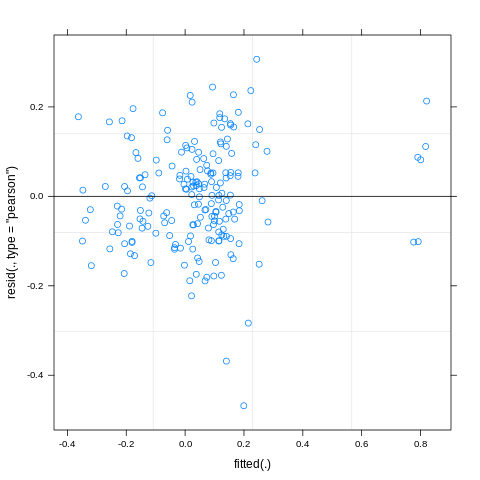

In [24]:
%%R 
plot(lmod)

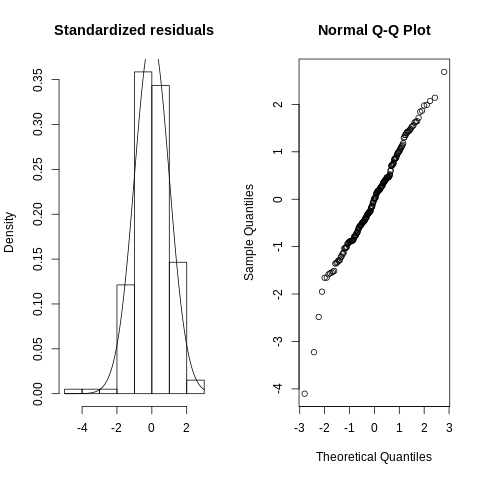

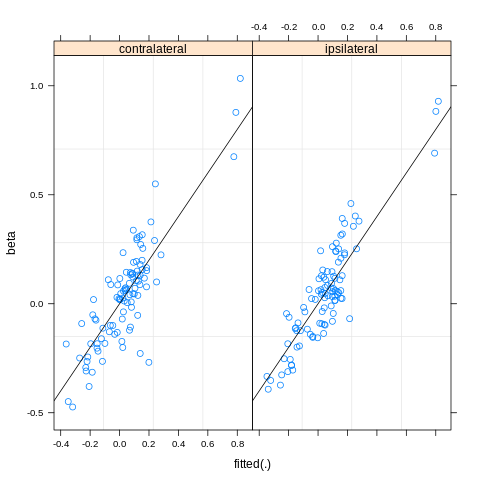

In [25]:
%%R 
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | laterality, abline = c(0,1))

## GLM3

In [26]:
def combine_difficulty(x):
    x['next_event'] = x['event_type'].shift(-1)
    x['event_type'] = x['event_type'] + '_' + x['next_event']
    x = x.loc[x['event_type'].isin(['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])]
    return x[['onset', 'event_type', 'duration']]

tmp = events.copy().reset_index()
tmp = tmp.loc[tmp['event_type'].isin(['easy', 'hard', 'error', 'correct'])]
stim_diff = tmp.groupby(['subject', 'run']).apply(lambda x: combine_difficulty(x)).reset_index(level=2, drop=True)

tmp = events.copy()
tmp = tmp.loc[tmp['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_3 = pd.concat([tmp, stim_diff]).sort_values(['subject', 'run', 'onset'])

In [27]:
# def combine_difficulty_accuracy(x):
#     return '_'.join(x['event_type'].values)

# events_1c = events.copy().reset_index()
# events_1c = events_1c.loc[events_1c['event_type'].isin(['cue_payoff', 'easy', 'hard', 'cue_neutral', 'error', 'correct'])]
# events_1c = events_1c.groupby(['subject', 'run', 'onset']).apply(lambda x: combine_difficulty_accuracy(x)).reset_index().set_index(['subject', 'run'])
# events_1c = events_1c.rename(columns={0: 'event_type'})

# events_1c.loc[events_1c['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'
# events_1c = events_1c.loc[~events_1c['event_type'].isin(['response_left', 'response_right'])]
# events_1c.head()

In [28]:
glm3 = GroupResponseFitter(df.copy(), 
                            events_3, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_3.event_type.unique():
    glm3.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm3.fit()

# get timecourses
tc = glm3.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event hard_correct is not available for run (1, 1). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python

,mask,t,p,p.fdr,contrast
0,signal_l_A,0.813289,0.422063,0.844126,glm3
1,signal_l_B,-0.273456,0.786260,0.943512,glm3
2,signal_l_C,0.035548,0.971864,0.971864,glm3
3,signal_r_A,1.004254,0.322790,0.844126,glm3
4,signal_r_B,0.295328,0.769651,0.943512,glm3
5,signal_r_C,1.865190,0.071347,0.428083,glm3


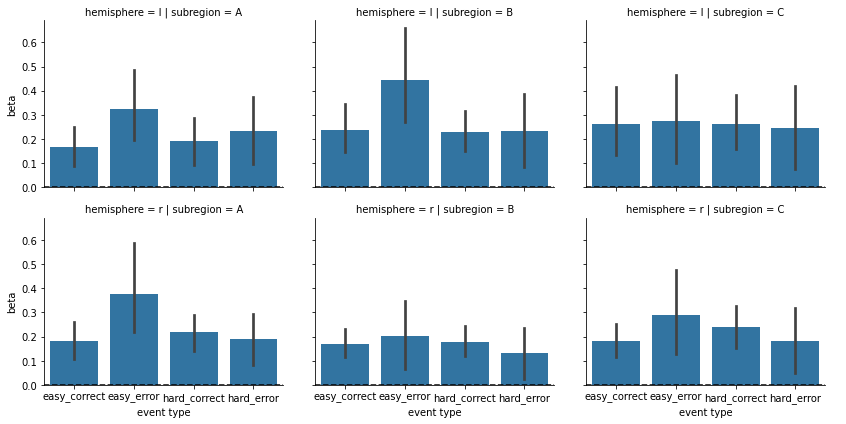

In [30]:
## long format for plotting
GLM3_betas_long = glm3.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_payoff', 'cue_neutral', 'easy_correct', 'hard_correct', 'easy_error', 'hard_error'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM3_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM3_betas_long['hemisphere'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM3_betas_long['subregion'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM3_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM3_betas_long.roi.unique():
    deg_free = GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'hard_correct'), 'beta'],
                                       GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'easy_correct'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm3'
results_glm3 = results.copy()
display(results)

In [31]:
GLM3_betas_longR = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct'])]
GLM3_betas_longR = GLM3_betas_longR.rename(columns={'event type': 'event_type'})
GLM3_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion
33,signal_l_A,easy_correct,1,0.714642,l,A
34,signal_l_A,easy_correct,2,0.469944,l,A
35,signal_l_A,easy_correct,3,-0.237582,l,A
36,signal_l_A,easy_correct,4,0.089153,l,A
37,signal_l_A,easy_correct,5,-0.033017,l,A
...,...,...,...,...,...,...
952,signal_r_C,hard_correct,30,0.296102,r,C
953,signal_r_C,hard_correct,31,0.455141,r,C
954,signal_r_C,hard_correct,32,0.097869,r,C
955,signal_r_C,hard_correct,33,0.269967,r,C


In [32]:
GLM3_betas_longR2 = GLM3_betas_longR.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()

In [33]:
%%R -i GLM3_betas_longR -i GLM3_betas_longR2 -i results_glm3 -o results_glm3
library(BayesFactor)
GLM3_betas_longR$event_type <- factor(GLM3_betas_longR$event_type)
GLM3_betas_longR$hemisphere <- factor(GLM3_betas_longR$hemisphere)
GLM3_betas_longR$subregion <- factor(GLM3_betas_longR$subregion)

b1 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'A','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'B','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'C','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'A','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'B','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'C','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'C','beta'], paired=TRUE)

results_glm3[results_glm3$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm3[results_glm3$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm3[results_glm3$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm3[results_glm3$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm3[results_glm3$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm3[results_glm3$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

# Bayes
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM3_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM3_betas_longR2) 
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.252758763988638"
[1] "BF10 for L B: 0.192817742532768"
[1] "BF10 for L C: 0.186324090773553"
[1] "BF10 for R A: 0.296004687488289"
[1] "BF10 for R B: 0.193937381595007"
[1] "BF10 for R C: 0.871402151132238"
  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   5.362823  9.602609             9.919679
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               53.02334                          54.48714
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         96.54833
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      528.9419
Type III Analysis of Variance Table with Satterthwaite's method
                       S

## What about accuracy x difficulty?

In [34]:
GLM3_betas_longR2 = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct', 'hard_error', 'easy_error'])]
GLM3_betas_longR2 = GLM3_betas_longR2.rename(columns={'event type': 'event_type'})
GLM3_betas_longR2['difficulty'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_longR2['accuracy'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[1])

Type III Analysis of Variance Table with Satterthwaite's method
                     Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)   
accuracy            0.53277 0.53277     1 750.56  5.1603 0.023391 * 
difficulty          0.46589 0.46589     1 750.56  4.5126 0.033973 * 
accuracy:difficulty 0.92853 0.92853     1 750.56  8.9936 0.002799 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


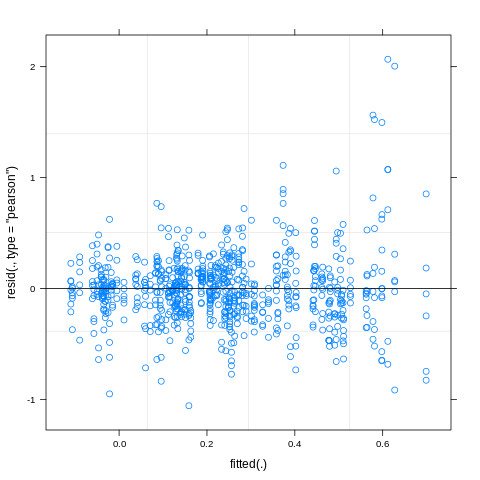

In [35]:
%%R -i GLM3_betas_longR2
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
# GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_longR2[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_longR2)
summary(lmod)
print(anova(lmod))
plot(lmod)

In [36]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

  replacement has 792 rows, data has 786




Error in `[<-.data.frame`(`*tmp*`, , ".y", value = c(0.714641812070089,  : 
  replacement has 792 rows, data has 786


#### The interaction appears significant, but the assumption checks look terrible (highly non-Gaussian, right-skewed residuals) Quite some subjects have very few errors in the easy condition, which leads to a very unstable beta-estimate. Let's see what the results look like when we only consider subs with >= 15 of these datapoints

In [37]:
counts = events_3.groupby(level=0).event_type.value_counts()#.reset_index()
counts.name = 'count'
counts = counts.reset_index()
drop_subs = counts.loc[(counts['event_type'] == 'easy_error') & (counts['count'] < 15), 'subject'].values

In [38]:
GLM3_betas_long_excl = GLM3_betas_long.copy()
GLM3_betas_long_excl = GLM3_betas_long_excl.loc[~(GLM3_betas_long_excl.subject.isin(drop_subs))]

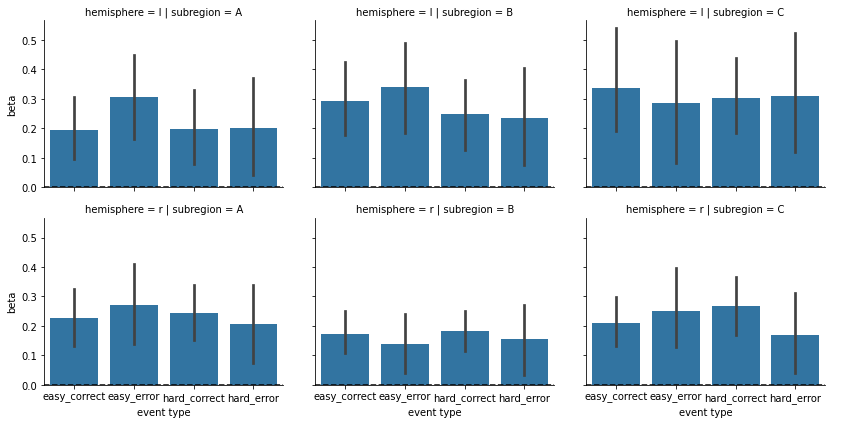

In [39]:
## Plot
fac = sns.FacetGrid(GLM3_betas_long_excl, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

In [40]:
GLM3_betas_long_excl = GLM3_betas_long_excl.rename(columns={'event type': 'event_type'})
GLM3_betas_long_excl['difficulty'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_long_excl['accuracy'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[1])


Interpret type III hypotheses with care.



Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
accuracy            6.0387 3.01934     2 657.36 37.1976 4.964e-16 ***
difficulty          0.0947 0.09465     1 657.65  1.1661    0.2806    
accuracy:difficulty 0.1024 0.10238     1 657.65  1.2613    0.2618    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


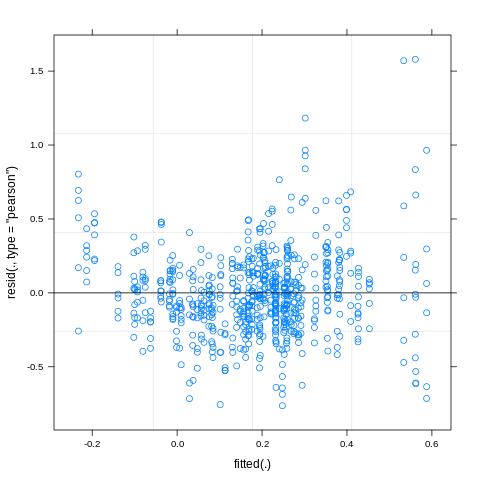

In [41]:
%%R -i GLM3_betas_long_excl
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
# GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_long_excl[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_long_excl)
summary(lmod)
print(anova(lmod))
plot(lmod)

In [42]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

  replacement has 690 rows, data has 684




Error in `[<-.data.frame`(`*tmp*`, , ".y", value = c(0.0176946335788358,  : 
  replacement has 690 rows, data has 684


#### Residuals look (a bit) better now, and the interaction effect is gone

# GLM4

In [43]:
events_4 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral', 'response_left', 'response_right'])]
events_4.loc[events_4['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm4 = GroupResponseFitter(df.copy(), 
                            events_4, 
                            confounds=confounds,
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_4.event_type.unique():
    glm4.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm4.fit()

# get timecourses
tc = glm4.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/si

,mask,t,p,p.fdr,contrast
0,signal_l_A,-1.684581,0.101800,0.569543,glm4
1,signal_l_B,-1.339489,0.189848,0.569543,glm4
2,signal_l_C,-0.016607,0.986853,0.986853,glm4
3,signal_r_A,0.436382,0.665490,0.798588,glm4
4,signal_r_B,0.476363,0.637052,0.798588,glm4
5,signal_r_C,-0.704953,0.485939,0.798588,glm4


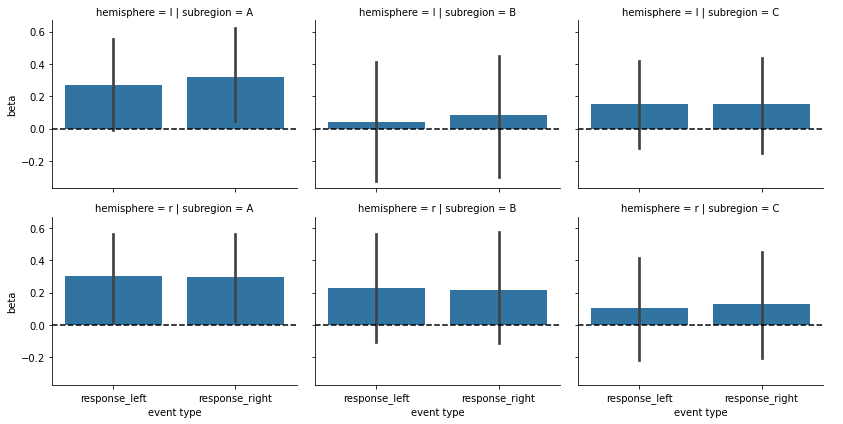

In [44]:
# ## long format for plotting
GLM4_betas_long = glm4.concat_response_fitters.apply(lambda x: x.betas.loc[(['response_left', 'response_right'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM4_betas_long.columns = ['roi', 'event type', 'subject', 'beta']

GLM4_betas_long['hemisphere'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM4_betas_long['subregion'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM4_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['response_left', 'response_right'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM4_betas_long.roi.unique():
    deg_free = GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_left'), 'beta'],
                                       GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_right'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm4'
results_glm4 = results.copy()
display(results)

In [45]:
GLM4_betas_longR = GLM4_betas_long.loc[GLM4_betas_long['event type'].isin(['response_left', 'response_right'])]
GLM4_betas_longR = GLM4_betas_longR.rename(columns={'event type': 'event_type'})

GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion,event_type2
0,signal_l_A,response_left,1,0.039849,l,A,ipsilateral
1,signal_l_A,response_left,2,0.786173,l,A,ipsilateral
2,signal_l_A,response_left,3,2.444301,l,A,ipsilateral
3,signal_l_A,response_left,4,0.427816,l,A,ipsilateral
4,signal_l_A,response_left,5,1.523594,l,A,ipsilateral
...,...,...,...,...,...,...,...
391,signal_r_C,response_right,30,0.147508,r,C,ipsilateral
392,signal_r_C,response_right,31,-1.416739,r,C,ipsilateral
393,signal_r_C,response_right,32,0.064202,r,C,ipsilateral
394,signal_r_C,response_right,33,0.023314,r,C,ipsilateral


In [46]:
GLM4_betas_longR2 = GLM4_betas_longR.groupby(['subject', 'event_type', 'event_type2', 'subregion']).beta.mean().reset_index()

In [47]:
%%R -i GLM4_betas_longR -i GLM4_betas_longR2 -i results_glm4 -o results_glm4
library(BayesFactor)
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type)
GLM4_betas_longR$hemisphere <- factor(GLM4_betas_longR$hemisphere)
GLM4_betas_longR$subregion <- factor(GLM4_betas_longR$subregion)

b1 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'A','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'B','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'C','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'A','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'B','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'C','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'C','beta'], paired=TRUE)

#results_glm4$bf <- NA
results_glm4[results_glm4$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm4[results_glm4$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm4[results_glm4$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm4[results_glm4$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm4[results_glm4$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm4[results_glm4$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

# ipsi/contralateral coding
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type2)
GLM4_betas_longR2$event_type <- factor(GLM4_betas_longR2$event_type2)

# Bayes
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM4_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM4_betas_longR2)
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.663194028411283"
[1] "BF10 for L B: 0.420750438619317"
[1] "BF10 for L C: 0.186238241126527"
[1] "BF10 for R A: 0.203463231908209"
[1] "BF10 for R B: 0.20693481259385"
[1] "BF10 for R C: 0.234398251269951"
  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   8.886113   11.1772             18.89183
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only                102.371                          166.3564
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         215.7736
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      1973.077
Type III Analysis of Variance Table with Satterthwaite's method
                      Sum

## No differences between subregions

## Table 1 in paper

In [51]:
all_stats = pd.concat([results_cue, results_difficulty, results_glm2, results_glm3, results_glm4])
all_stats['bf01'] = 1/all_stats['bf10']

In [52]:
table1_full = all_stats.melt(id_vars=['mask', 'contrast'], value_vars=['t', 'p', 'p.fdr', 'bf01']).pivot_table(values='value', index='mask', columns=['contrast', 'variable']).round(3)

In [53]:
table1_paper = table1_full.iloc[:, table1_full.columns.get_level_values(1).isin(['t', 'bf01'])]
table1_paper = table1_paper.reindex(columns=['t', 'bf01'], level=1)
table1_paper.round(2)

contrast   glm1_cue       glm1_difficulty       glm2_cues        glm3        \
variable          t  bf01               t  bf01         t  bf01     t  bf01   
mask                                                                          
signal_l_A     0.45  4.90           -0.48  4.82     -0.01  5.37  0.81  3.96   
signal_l_B     0.98  3.46            0.45  4.89      0.86  3.83 -0.27  5.19   
signal_l_C     1.04  3.27           -0.70  4.28     -0.93  3.62  0.04  5.37   
signal_r_A     1.42  2.14           -0.25  5.22     -0.81  3.96  1.00  3.38   
signal_r_B     0.78  4.04           -0.33  5.10     -0.66  4.38  0.30  5.16   
signal_r_C     1.75  1.36           -0.73  4.18      0.13  5.33  1.86  1.15   

contrast    glm4        
variable       t  bf01  
mask                    
signal_l_A -1.68  1.51  
signal_l_B -1.34  2.38  
signal_l_C -0.02  5.37  
signal_r_A  0.44  4.92  
signal_r_B  0.48  4.83  
signal_r_C -0.70  4.27

### Plot

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


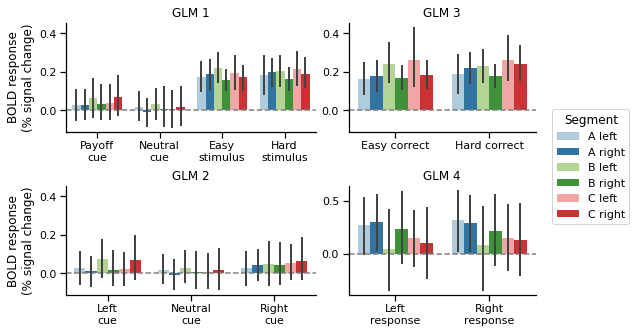

In [ ]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

ci = 95

f = plt.figure(figsize=(9,5))
gridspec = f.add_gridspec(ncols=2, nrows=2, 
                          wspace=.15, hspace=0.5,
                          width_ratios=[4,3])
# left/right
ax0 = f.add_subplot(gridspec[0,0])
ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
ax2 = f.add_subplot(gridspec[1,0], sharey=ax0)
ax3 = f.add_subplot(gridspec[1,1])#, sharey=ax2)
ax = [ax0, ax1, ax2, ax3]

# f, ax = plt.subplots(1,4)#,  sharey='row')
for ax_ in ax:
    ax_.axhline(0, color='grey', linestyle='--')

b1 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM1_betas_long, 
                 ax=ax[0], ci=ci, errwidth=2, #capsize=.05,
                 order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
h, l = ax[0].get_legend_handles_labels() #.remove()
b1.legend_.remove()
ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
ax[0].set_title('GLM 1')
ax[0].set_ylabel('BOLD response\n(% signal change)')

b2 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM2_betas_long,
                 ax=ax[2], ci=ci, errwidth=2,
                 order=['cue_left', 'cue_neutral', 'cue_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b2.legend_.remove()
ax[2].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
ax[2].set_title('GLM 2')

b3 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['easy_correct', 'hard_correct'])],
                 ax=ax[1], ci=ci, errwidth=2,
                 order=['easy_correct', 'hard_correct'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b3.legend_.remove()
ax[1].set_xticklabels(['Easy correct', 'Hard correct'])#, rotation=30, ha='right')
ax[1].set_title('GLM 3')
#ax[2].set_ylabel('BOLD response\n(% signal change)')

b4 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM4_betas_long,
                 ax=ax[3], ci=ci,errwidth=2, 
                 order=['response_left', 'response_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b4.legend_.remove()
ax[3].set_title('GLM 4')
ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
#ax[3].yaxis.set_ticklabels([])

#ax[3].tick_params(labelleft=False)
#ax[1].tick_params(labelleft=False)
#ax[2].yaxis.set_ticklabels([])

for ax_ in ax:
    ax_.set_xlabel('')
for ax_ in [ax[1], ax[3]]:
    ax_.set_ylabel('')
ax[2].set_ylabel('BOLD response\n(% signal change)')

sns.despine()

f.tight_layout()
f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Segment')
f.subplots_adjust(right=.85)
#f.set_size_inches(15,4)

In [ ]:
f.savefig('figures/figure4_95ci_pca.pdf', bbox_inches='tight')

In [ ]:
# this messes up the height of the y-axis...

In [ ]:
# sns.set_context('notebook')
# font = {'size'   : 14}
# import matplotlib
# matplotlib.rc('font', **font)

# f = plt.figure(figsize=(9,5))
# gridspec = f.add_gridspec(ncols=2, nrows=2, 
#                           wspace=.1, hspace=0.5,
#                           width_ratios=[4,3])
# # left/right
# ax0 = f.add_subplot(gridspec[0,0])
# ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
# ax2 = f.add_subplot(gridspec[1,0])
# ax3 = f.add_subplot(gridspec[1,1], sharey=ax2)
# ax = [ax0, ax1, ax2, ax3]

# # f, ax = plt.subplots(1,4)#,  sharey='row')
# for ax_ in ax:
#     ax_.axhline(0, color='grey', linestyle='--')

# b1 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM1_betas_long, 
#                  ax=ax[0], ci=67, errwidth=2, #capsize=.05,
#                  order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# h, l = ax[0].get_legend_handles_labels() #.remove()
# b1.legend_.remove()
# ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
# ax[0].set_title('GLM 1')
# ax[0].set_ylabel('Beta')

# b2 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM2_betas_long,
#                  ax=ax[1], ci=67, errwidth=2,
#                  order=['cue_left', 'cue_neutral', 'cue_right'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b2.legend_.remove()
# ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
# ax[1].set_title('GLM 2')

# b3 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM3_betas_long,
#                  ax=ax[2], ci=67, errwidth=2,
#                  order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b3.legend_.remove()
# ax[2].set_xticklabels(['Easy\ncorrect', 'Easy\nerror', 'Hard\ncorrect', 'Hard\nerror'])#, rotation=30, ha='right')
# ax[2].set_title('GLM 3')
# ax[2].set_ylabel('Beta')

# b4 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM4_betas_long,
#                  ax=ax[3], ci=67,errwidth=2, 
#                  order=['response_left', 'response_right'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b4.legend_.remove()
# ax[3].set_title('GLM 4')
# ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
# #ax[3].yaxis.set_ticklabels([])

# ax[3].tick_params(labelleft=False)
# ax[1].tick_params(labelleft=False)
# #ax[2].yaxis.set_ticklabels([])


# for ax_ in ax:
#     ax_.set_xlabel('')
# for ax_ in [ax[1], ax[3]]:
#     ax_.set_ylabel('')
# ax[2].set_ylabel('Beta')

# sns.despine()

# f.tight_layout()
# f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Subregion')
# f.subplots_adjust(right=.85)
# #f.set_size_inches(15,4)
